## Analysis and  Model Development

This document outlines the process of exploratory data analysis for climate and 
economic data. There are two main components:
1. Data cleaning and Missing values
Indicators with more than 35% of missing values are dropped. Further, countries
with more than 35% of the data missing are also dropped from the panel dataset.

2. Data Imputation
We use KNNImputer from sklearn to do missing value imputation. 

3. Model Development

    * PooledOLS- Linear regression on Panel dataset. This is not the appropriate 
    model to study the relationship between CO2 emissions per capita and gdp per 
    capita because it does not account for fixed effects. 
    * PanelOLS to do Fixed Effects Regressions. This model incorporates time fixed 
    effects. We use the results from this model in the dashboard.

The benchhmark model to study Environmental Kuznets Curve relationship is 

$logCO2capita = \beta_0 + \beta_1 logGDPcapita + \beta_2 (logGDPcapita)^2$




In [10]:
#Import libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pooled OLS
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
# FE  model
from linearmodels import PanelOLS
from sklearn.impute import KNNImputer

In [11]:
# Create your connection.
con = sqlite3.connect('../data/indicators.sqlite3', check_same_thread=False)

In [12]:
# Import dataset as pandas dataframe
climate_data = pd.read_sql_query("SELECT * FROM climate_indicators", con)
economic_data = pd.read_sql_query("SELECT * FROM econ_indicators", con)
region_mapping = pd.read_sql_query("SELECT * FROM region_mapping", con)

### Exploring climate data

In [13]:
#print the head of the data frame.
climate_data.head()

,country,iso_code,year,co2_emissions_kt,co2_emissions_capita,forest_area,population,electricity_pro_hydro,electricity_pro_natural_gas,electricity_pro_nuclear,electricity_pro_oil,electricity_pro_coal,electricity_pro_fossils,electricity_pro_renewable,pm_25,sf6_emissions,ghg_total,ghg_growth,ghg_capita,mean_surface_temp
0,Aruba,ABW,1995,NaN,NaN,2.333333,80324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.573
1,Aruba,ABW,1996,NaN,NaN,2.333333,83211.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.727
2,Aruba,ABW,1997,NaN,NaN,2.333333,85450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aruba,ABW,1998,NaN,NaN,2.333333,87280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aruba,ABW,1999,NaN,NaN,2.333333,89009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
climate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      5250 non-null   object 
 1   iso_code                     5250 non-null   object 
 2   year                         5250 non-null   int64  
 3   co2_emissions_kt             4584 non-null   float64
 4   co2_emissions_capita         4584 non-null   float64
 5   forest_area                  5134 non-null   float64
 6   population                   5217 non-null   float64
 7   electricity_pro_hydro        2903 non-null   float64
 8   electricity_pro_natural_gas  2903 non-null   float64
 9   electricity_pro_nuclear      2798 non-null   float64
 10  electricity_pro_oil          2903 non-null   float64
 11  electricity_pro_coal         2903 non-null   float64
 12  electricity_pro_fossils      2903 non-null   float64
 13  electricity_pro_re

In [15]:
climate_data.shape

(5250, 20)

### Missing values analysis

In [16]:
percent_missing = climate_data.isnull().sum() * 100 / len(climate_data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
country,0.000000
iso_code,0.000000
year,0.000000
co2_emissions_kt,12.685714
co2_emissions_capita,12.685714
forest_area,2.209524
population,0.628571
electricity_pro_hydro,44.704762
electricity_pro_natural_gas,44.704762
electricity_pro_nuclear,46.704762


As electricity production variables, pm25 and sf6 emissions have more almost 50%
of data missing, we can drop these variables. We drop variables with more than 
35% of data.

In [17]:
perc = 35.0
min_count =  int(((100-perc)/100)*climate_data.shape[0] + 1)
climate_data = climate_data.dropna(axis = 1, thresh = min_count)
climate_data.columns

Index(['country', 'iso_code', 'year', 'co2_emissions_kt',
       'co2_emissions_capita', 'forest_area', 'population', 'ghg_total',
       'ghg_growth', 'ghg_capita', 'mean_surface_temp'],
      dtype='object')

In [18]:
def missing_values_graph(frame, obs, time, var, Yname):
    test = frame[[obs, time, var]]
    test[var].fillna(-1, inplace=True)
    test = test.groupby([obs, time])[var].aggregate('mean').unstack()
    test[test > 0] = 1
    cmap = sns.xkcd_palette(["grey", "blue"])
    plt.figure(figsize=(10, 5))
    ax = sns.heatmap(test, center=0, cmap=cmap, cbar=False,
                     cbar_kws={'ticks': [-1, 0, 1]})
    ax.set(yticklabels=[])
    plt.ylabel(Yname+ " (N=" + str(len(test)) + ")", fontsize=14)
    plt.xlabel("")
    plt.title((var + "\n missing values (grey), availabe values (blue)"),
              fontsize=14)
    plt.tight_layout()
    plt.show()

The above function creates a graph for the variable of interest. On the y-axsis you see the the observations (names in this case). On the x-axis you see the years. Available values are highlighed blue, while missing data are grey.

<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


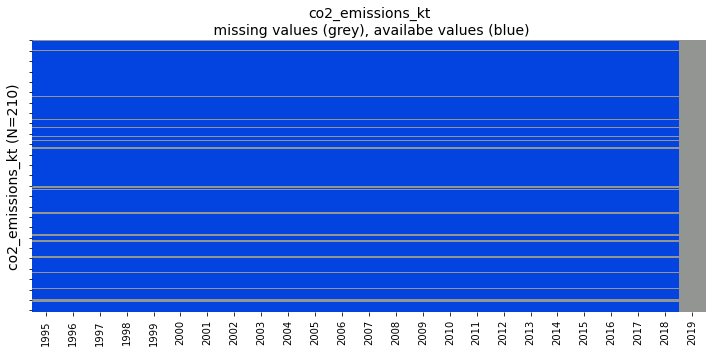

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


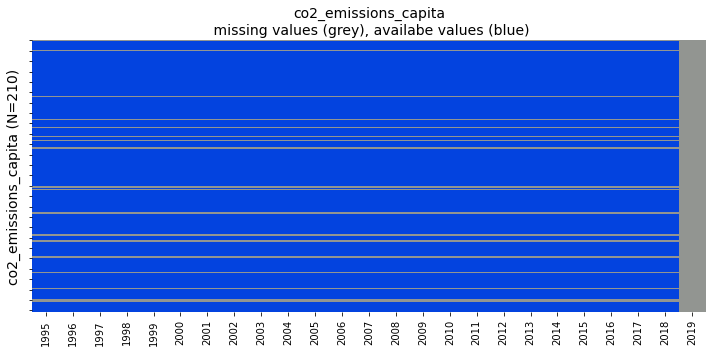

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


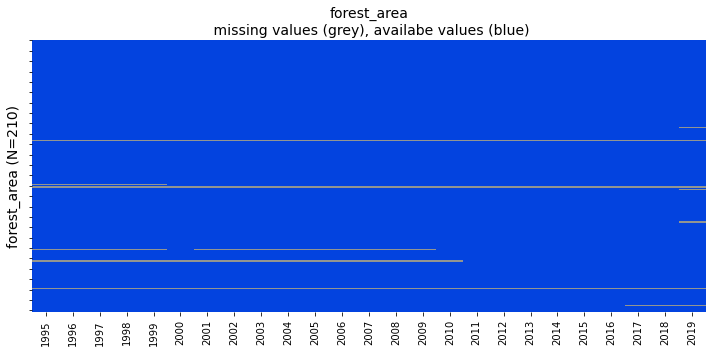

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


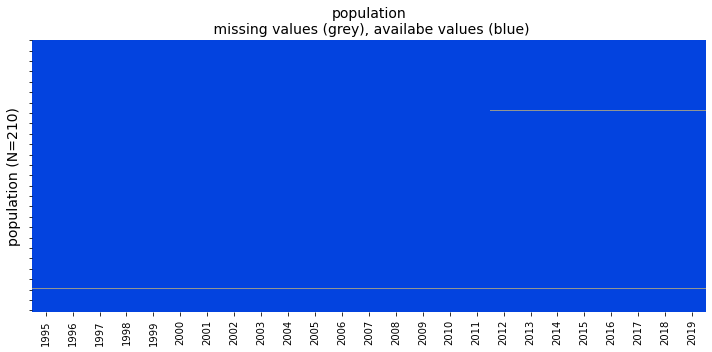

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


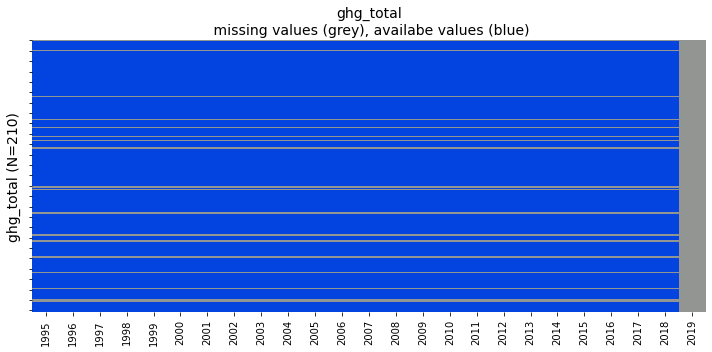

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


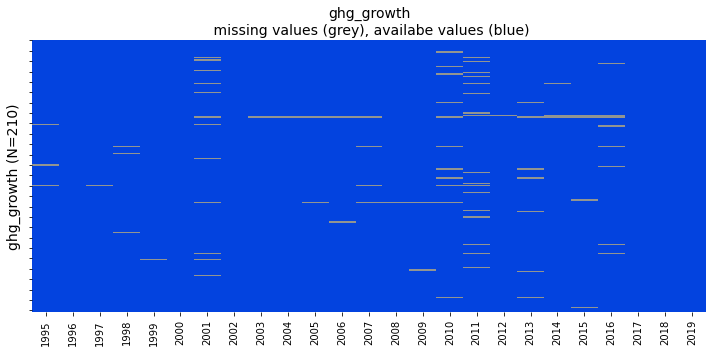

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


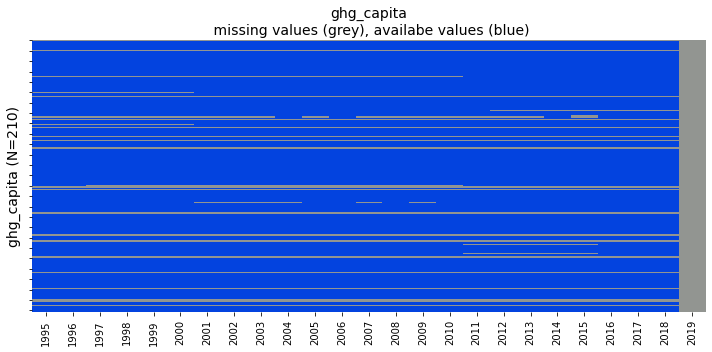

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


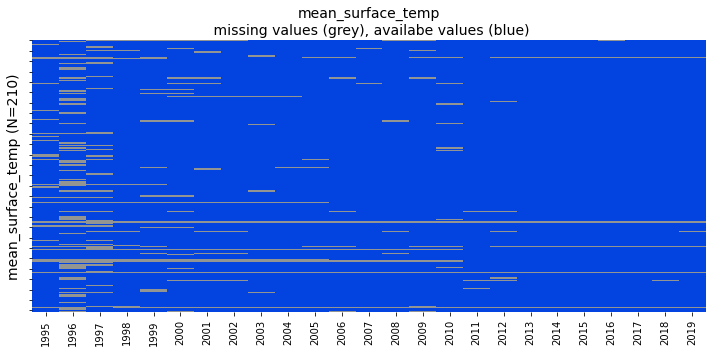

None


In [19]:
for col in climate_data.columns[3:]:
    print(missing_values_graph(climate_data, "iso_code", "year", col, col))

### Exploring economic data

In [20]:
economic_data.head()

,country,iso_code,year,gdp_constant_change,gdp_capita,vol_imports_change,vol_exports_change,population,gdp_current,energy_usage,imports_gns,exports_gns
0,Afghanistan,AFG,1995,,,,,,,,,
1,Albania,ALB,1995,8.9,4582.93,0.0,,3.188,9.643,417.034843,,
2,Algeria,DZA,1995,3.848,8158.72,2.0,5.733,28.06,204.348,843.041996,16590532511.0,33084611492.0
3,Angola,AGO,1995,10.364,3973.12,27.968,12.24,14.771,37.582,455.666087,,
4,Antigua and Barbuda,ATG,1995,-4.359,16127.97,,,0.067,0.909,,,


In [21]:
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070 entries, 0 to 5069
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              5070 non-null   object
 1   iso_code             5070 non-null   object
 2   year                 5070 non-null   int64 
 3   gdp_constant_change  5070 non-null   object
 4   gdp_capita           5070 non-null   object
 5   vol_imports_change   5070 non-null   object
 6   vol_exports_change   5070 non-null   object
 7   population           5070 non-null   object
 8   gdp_current          5070 non-null   object
 9   energy_usage         5070 non-null   object
 10  imports_gns          5070 non-null   object
 11  exports_gns          5070 non-null   object
dtypes: int64(1), object(11)
memory usage: 475.4+ KB


In [22]:
# convert string columns to numeric dtype
for col in economic_data.columns[3:]:
    economic_data[col]=pd.to_numeric(economic_data[col])
economic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5070 entries, 0 to 5069
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              5070 non-null   object 
 1   iso_code             5070 non-null   object 
 2   year                 5070 non-null   int64  
 3   gdp_constant_change  4932 non-null   float64
 4   gdp_capita           4926 non-null   float64
 5   vol_imports_change   4399 non-null   float64
 6   vol_exports_change   4425 non-null   float64
 7   population           4948 non-null   float64
 8   gdp_current          4957 non-null   float64
 9   energy_usage         2851 non-null   float64
 10  imports_gns          3730 non-null   float64
 11  exports_gns          3730 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 475.4+ KB


In [23]:
percent_missing = economic_data.isnull().sum() * 100 / len(climate_data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
country,0.000000
iso_code,0.000000
year,0.000000
gdp_constant_change,2.628571
gdp_capita,2.742857
vol_imports_change,12.780952
vol_exports_change,12.285714
population,2.323810
gdp_current,2.152381
energy_usage,42.266667


In [24]:
economic_data.shape

(5070, 12)

In [25]:
perc = 35.0
min_count =  int(((100-perc)/100)*economic_data.shape[0] + 1)
economic_data = economic_data.dropna(axis = 1, thresh = min_count)
economic_data.shape

(5070, 11)

<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


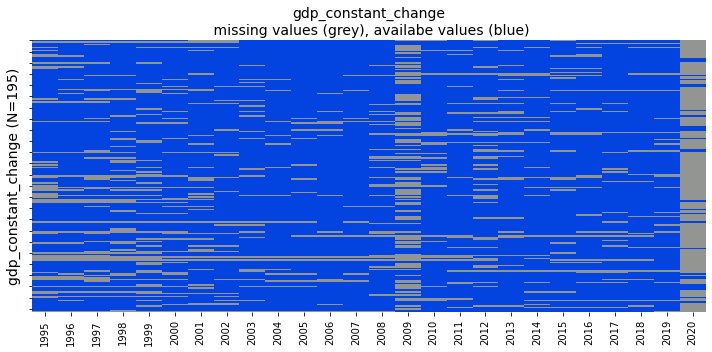

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


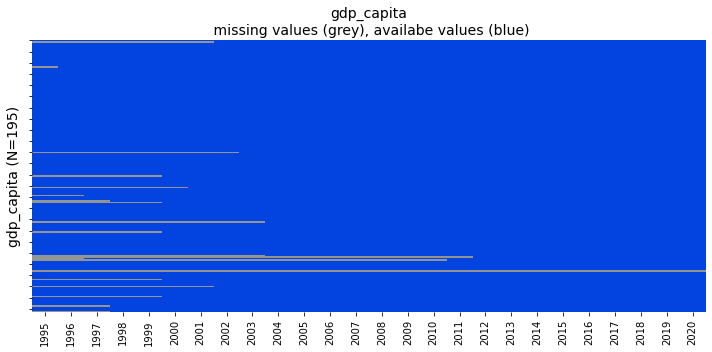

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


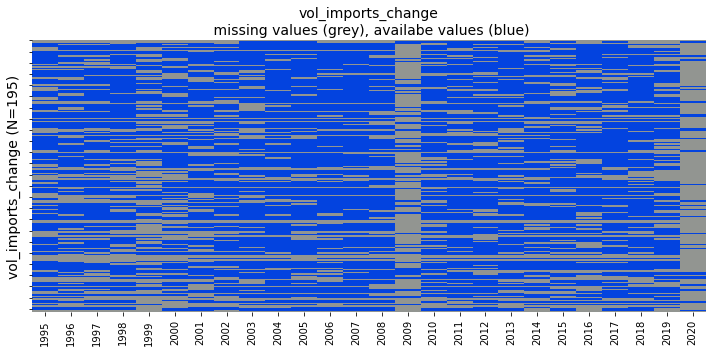

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


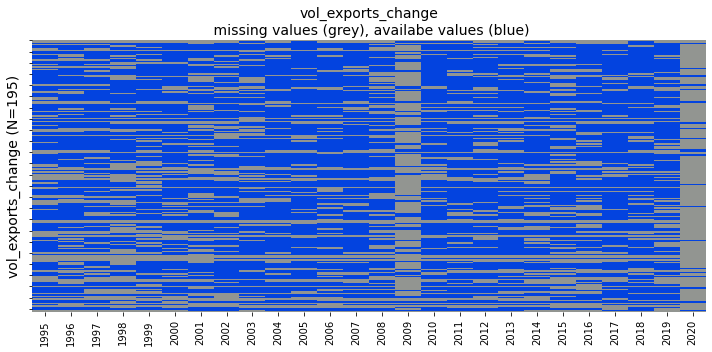

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


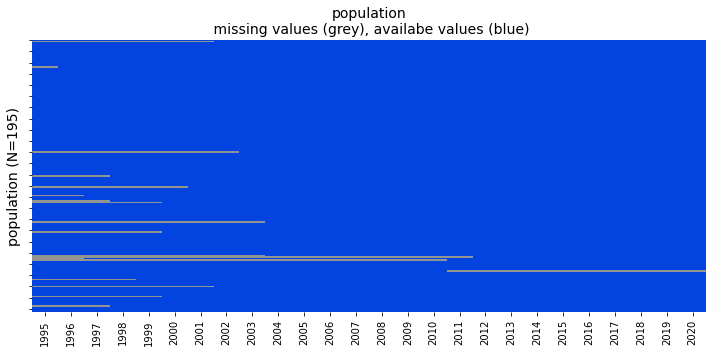

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


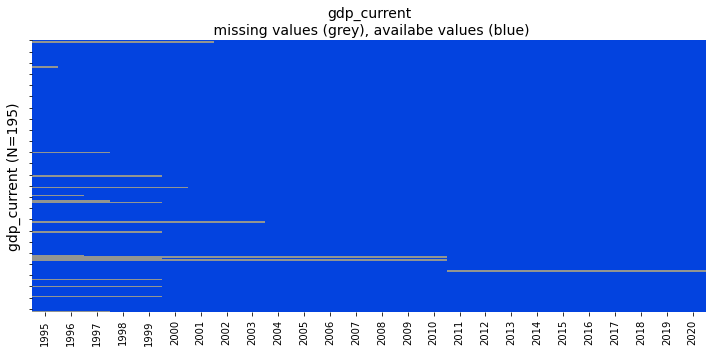

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


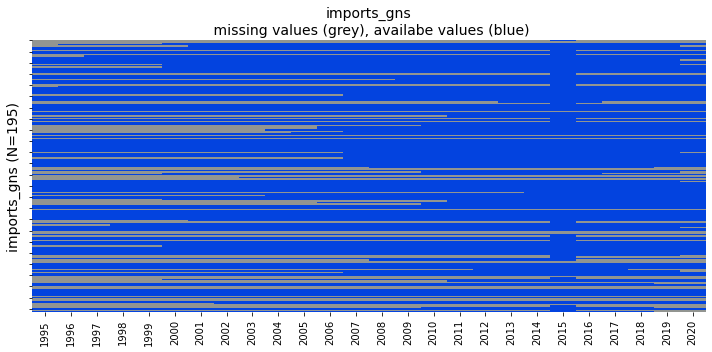

None


<ipython-input-18-3bd2c6c465af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[var].fillna(-1, inplace=True)


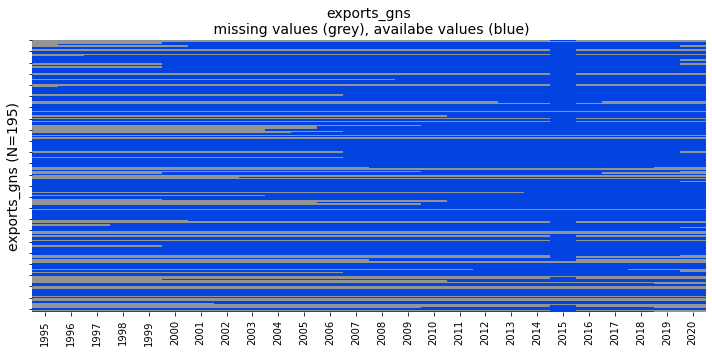

None


In [26]:
for col in economic_data.columns[3:]:
    print(missing_values_graph(economic_data, "iso_code", "year", col, col))

# Selecting Countries for Region Specific Analysis

We want to keep countries for which we have enough data to perform further analysis. We start by looking at the percentage of missing values for each country, and ddrop the countries for which this proportion is greater than 35%. 

In [27]:
combined_data = pd.merge(economic_data, climate_data, on = ["iso_code", "year", "country"], how = "left")
combined_data.head()

,country,iso_code,year,gdp_constant_change,gdp_capita,vol_imports_change,vol_exports_change,population_x,gdp_current,imports_gns,exports_gns,co2_emissions_kt,co2_emissions_capita,forest_area,population_y,ghg_total,ghg_growth,ghg_capita,mean_surface_temp
0,Afghanistan,AFG,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250.0,0.069020,1.850994,18110662.0,13480.0,1.88,0.61,0.401
1,Albania,ALB,1995,8.900,4582.93,0.000,NaN,3.188,9.643,NaN,NaN,1950.0,0.611710,28.432482,3187784.0,7430.0,-3.06,2.39,-0.127
2,Algeria,DZA,1995,3.848,8158.72,2.000,5.733,28.060,204.348,1.659053e+10,3.308461e+10,73050.0,2.540181,0.681435,28757788.0,103000.0,4.23,3.60,0.619
3,Angola,AGO,1995,10.364,3973.12,27.968,12.240,14.771,37.582,NaN,NaN,10780.0,0.773026,62.954757,13945205.0,48460.0,6.50,5.12,0.827
4,Antigua and Barbuda,ATG,1995,-4.359,16127.97,NaN,NaN,0.067,0.909,NaN,NaN,270.0,3.931733,22.227273,68672.0,460.0,6.14,6.69,0.522


In [28]:
def missing_data_prop(df):
    perc = 35.0
    min_count =  int(((100-perc)/100)*df.shape[0] + 1)
    df = df.dropna(axis = 1, thresh = min_count)
    return df

In [22]:
# 
drop_countries = []
for country in combined_data["iso_code"].unique():
    df = combined_data[combined_data["iso_code"] == country]
    df_clean = missing_data_prop(df)
    if df.shape[1] != df_clean.shape[1]:
        drop_countries.append(country)

combined_data = combined_data[combined_data.iso_code.isin(drop_countries) == False]

In [23]:
#114 countries left
len(combined_data.iso_code.unique())

114

# Pooled OLS

In [30]:
#merged climate data and economic data
data = combined_data.copy()
data.head()

,country,iso_code,year,gdp_constant_change,gdp_capita,vol_imports_change,vol_exports_change,population_x,gdp_current,imports_gns,exports_gns,co2_emissions_kt,co2_emissions_capita,forest_area,population_y,ghg_total,ghg_growth,ghg_capita,mean_surface_temp
0,Afghanistan,AFG,1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1250.0,0.069020,1.850994,18110662.0,13480.0,1.88,0.61,0.401
1,Albania,ALB,1995,8.900,4582.93,0.000,NaN,3.188,9.643,NaN,NaN,1950.0,0.611710,28.432482,3187784.0,7430.0,-3.06,2.39,-0.127
2,Algeria,DZA,1995,3.848,8158.72,2.000,5.733,28.060,204.348,1.659053e+10,3.308461e+10,73050.0,2.540181,0.681435,28757788.0,103000.0,4.23,3.60,0.619
3,Angola,AGO,1995,10.364,3973.12,27.968,12.240,14.771,37.582,NaN,NaN,10780.0,0.773026,62.954757,13945205.0,48460.0,6.50,5.12,0.827
4,Antigua and Barbuda,ATG,1995,-4.359,16127.97,NaN,NaN,0.067,0.909,NaN,NaN,270.0,3.931733,22.227273,68672.0,460.0,6.14,6.69,0.522


In [31]:
data["log_co2_capita"] = np.log(data["co2_emissions_capita"])
data["log_gdp_capita"] = np.log(pd.to_numeric(data["gdp_capita"]))
data["log_gdp_capita_sq"] = (np.log(pd.to_numeric(data["gdp_capita"])))**2

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
# Perform PooledOLS
data['year'] = pd.to_datetime(data['year'], format='%Y')
# #add column year to index
data = data.set_index('year', append=True)

In [34]:
#exog = sm.tools.tools.add_constant(data["log_gdp_capita"])
exog = sm.tools.tools.add_constant(data.filter(["log_gdp_capita", "log_gdp_capita_sq", "vol_exports_change", "vol_imports_change", "mean_surface_temp"], axis = 1))
endog = data["log_co2_capita"]
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

/home/kaveri/.local/lib/python3.8/site-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [35]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:         log_co2_capita   R-squared:                        0.8595
Estimator:                  PooledOLS   R-squared (Between):              0.8595
No. Observations:                3557   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8595
Time:                        11:55:17   Log-likelihood                   -3167.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4343.9
Entities:                        3557   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                  F(5,3551)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             4409.1
                            

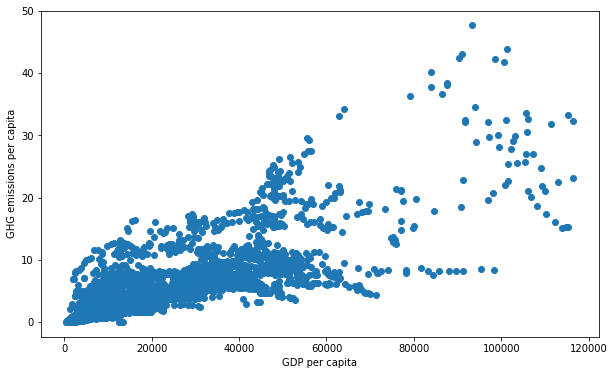

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = data['gdp_capita'], y = data["co2_emissions_capita"])
plt.xlabel("GDP per capita")
plt.ylabel("GHG emissions per capita")
plt.show()

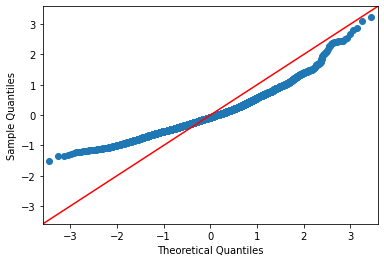

In [37]:
#QQPlot to check for normality
sm.qqplot(residuals_pooled_OLS, line='45')
plt.show()

The plot shows that the residuals of the plot are not normalaly distributed. Even though the residual errors are not normally distributed, the Pooled OLS estimator is still the Best Linear Unbiased Estimator (BLUE) for the panel data regression problem. Non-normality of residual errors does not affect the BLUE-ness of OLS regression model.

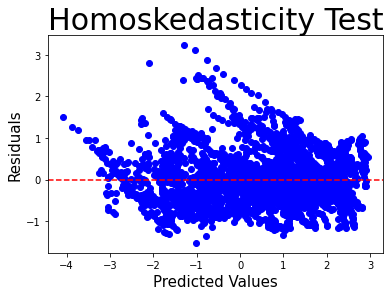

In [38]:
#  Homoskedasticity
# Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

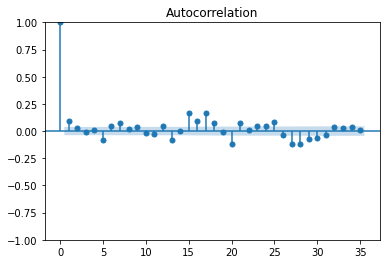

In [41]:
#check for autocorrelation
import statsmodels.graphics.tsaplots as tsap
tsap.plot_acf(x=residuals_pooled_OLS)
plt.show()

The perfect correlation of 1.0 at lag 0 is to be ignored as a number is always perfectly correlated with itself. But we see significant auto-correlation between residual errors at lags 1, 2 and 3.

# Fixed Effects Regression

In [88]:
data2 = combined_data.copy()
data2["log_co2_capita"] = np.log(data2["co2_emissions_capita"])
data2["log_gdp_capita"] = np.log(pd.to_numeric(data2["gdp_capita"]))
data2["log_gdp_capita_sq"] = (np.log(pd.to_numeric(data2["gdp_capita"])))**2
data2["net_exports"] = data2["exports_gns"] - data2["imports_gns"]
data2["log_net_exports"] = np.log(data2["net_exports"])

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [89]:
data2.columns

Index(['country', 'iso_code', 'year', 'gdp_constant_change', 'gdp_capita',
       'vol_imports_change', 'vol_exports_change', 'population_x',
       'gdp_current', 'imports_gns', 'exports_gns', 'co2_emissions_kt',
       'co2_emissions_capita', 'forest_area', 'population_y', 'ghg_total',
       'ghg_growth', 'ghg_capita', 'mean_surface_temp', 'log_co2_capita',
       'log_gdp_capita', 'log_gdp_capita_sq', 'net_exports',
       'log_net_exports'],
      dtype='object')

In [90]:
# 
drop_countries = []
for country in data2["iso_code"].unique():
    df = data2[data2["iso_code"] == country]
    df_clean = missing_data_prop(df)
    if df.shape[1] != df_clean.shape[1]:
        drop_countries.append(country)

data2 = data2[data2.iso_code.isin(drop_countries) == False]

In [91]:
# Imputing missing data grouped by countries
def impute_missing_values(df):
    imputer = KNNImputer(n_neighbors=2)
    X = df.iloc[:,3:]
    out = imputer.fit_transform(X)
    out1 = pd.DataFrame(out, columns = df.columns[3:])
    return out1

res = data2.groupby(["iso_code", "country"], as_index = False).apply(impute_missing_values)

In [92]:
res.iloc[:,1:]
res.reset_index(drop=True, inplace=True)
res.head()

,gdp_constant_change,gdp_capita,vol_imports_change,vol_exports_change,population_x,gdp_current,imports_gns,exports_gns,co2_emissions_kt,co2_emissions_capita,...,population_y,ghg_total,ghg_growth,ghg_capita,mean_surface_temp,log_co2_capita,log_gdp_capita,log_gdp_capita_sq,net_exports,log_net_exports
0,-2.845,17387.03,-11.484,25.559,34.779,347.223,2.737656e+10,3.314611e+10,113810.0,3.267757,...,34828168.0,260580.0,0.19,8.78,0.210,1.184104,9.763480,95.325538,5.769549e+09,22.475860
1,5.527,18130.83,19.483,6.395,35.196,373.122,3.217542e+10,3.568072e+10,126560.0,3.590724,...,35246376.0,272500.0,4.54,9.07,0.476,1.278354,9.805369,96.145263,3.505302e+09,21.977543
2,8.111,19376.36,30.046,15.133,35.604,410.342,4.082145e+10,4.002572e+10,127320.0,3.570644,...,35657438.0,274400.0,0.79,9.04,0.732,1.272746,9.871809,97.452614,-7.957339e+08,19.553738
3,3.850,19898.28,9.881,12.705,36.005,430.938,4.425614e+10,4.427781e+10,133170.0,3.692658,...,36063451.0,278480.0,1.18,9.04,0.320,1.306347,9.898389,97.978096,2.166769e+07,16.891333
4,-3.385,19016.97,-15.955,-2.148,36.399,422.360,3.926990e+10,4.371978e+10,134190.0,3.679743,...,36467218.0,283170.0,1.87,9.11,0.138,1.302843,9.853087,97.083324,4.449881e+09,22.216143


In [93]:
data2.iloc[:,:3]
data2.reset_index(drop=True, inplace=True)

In [94]:
frames = [data2.iloc[:,:3], res]
final_dataset = pd.concat(frames,  axis=1)

In [95]:
final_dataset.head()

,country,iso_code,year,gdp_constant_change,gdp_capita,vol_imports_change,vol_exports_change,population_x,gdp_current,imports_gns,...,population_y,ghg_total,ghg_growth,ghg_capita,mean_surface_temp,log_co2_capita,log_gdp_capita,log_gdp_capita_sq,net_exports,log_net_exports
0,Argentina,ARG,1995,-2.845,17387.03,-11.484,25.559,34.779,347.223,2.737656e+10,...,34828168.0,260580.0,0.19,8.78,0.210,1.184104,9.763480,95.325538,5.769549e+09,22.475860
1,Austria,AUT,1995,5.527,18130.83,19.483,6.395,35.196,373.122,3.217542e+10,...,35246376.0,272500.0,4.54,9.07,0.476,1.278354,9.805369,96.145263,3.505302e+09,21.977543
2,Bahrain,BHR,1995,8.111,19376.36,30.046,15.133,35.604,410.342,4.082145e+10,...,35657438.0,274400.0,0.79,9.04,0.732,1.272746,9.871809,97.452614,-7.957339e+08,19.553738
3,Belgium,BEL,1995,3.850,19898.28,9.881,12.705,36.005,430.938,4.425614e+10,...,36063451.0,278480.0,1.18,9.04,0.320,1.306347,9.898389,97.978096,2.166769e+07,16.891333
4,Botswana,BWA,1995,-3.385,19016.97,-15.955,-2.148,36.399,422.360,3.926990e+10,...,36467218.0,283170.0,1.87,9.11,0.138,1.302843,9.853087,97.083324,4.449881e+09,22.216143


In [96]:
final_data2 = pd.merge(final_dataset, region_mapping, on = [ "iso_code",], how = "left")
final_data2.columns

Index(['country_x', 'iso_code', 'year', 'gdp_constant_change', 'gdp_capita',
       'vol_imports_change', 'vol_exports_change', 'population_x',
       'gdp_current', 'imports_gns', 'exports_gns', 'co2_emissions_kt',
       'co2_emissions_capita', 'forest_area', 'population_y', 'ghg_total',
       'ghg_growth', 'ghg_capita', 'mean_surface_temp', 'log_co2_capita',
       'log_gdp_capita', 'log_gdp_capita_sq', 'net_exports', 'log_net_exports',
       'country_y', 'region', 'sub_region', 'intermediate_region'],
      dtype='object')

In [97]:
# region
asia_data = final_data2[final_data2["region"] == "Asia"]
africa_data = final_data2[final_data2["region"] == "Africa"]
europe_data = final_data2[final_data2["region"] == "Europe"]
americas_data = final_data2[final_data2["region"] == "Americas"]

In [98]:
#sub-region analysis
eastern_asia = final_data2[final_data2["sub_region"] == "Eastern Asia"]
south_eastern_asia = final_data2[final_data2["sub_region"] == "South-eastern Asia"]
central_asia = final_data2[final_data2["sub_region"] == "Central Asia"]
western_asia = final_data2[final_data2["sub_region"] == "Western Asia"]
northern_america = final_data2[final_data2["sub_region"] == "Northern America"]
latin_america = final_data2[final_data2["sub_region"] == "Latin America and the Caribbean"]

In [109]:
def fixed_effects_model(dataset, explanatory_variable = None):
    vars = ["log_gdp_capita", "log_gdp_capita_sq"]
    if explanatory_variable:
        vars.extend(explanatory_variable)
    exog_vars = vars + np.unique(dataset.year)[1::].tolist()
    dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')
    dataset = dataset.set_index('year', append=True)
    exog = sm.tools.tools.add_constant(dataset.filter(exog_vars, axis = 1))
    endog = dataset["log_co2_capita"]
    mod_fe = PanelOLS(endog, exog, time_effects=True)
    fe_res = mod_fe.fit()
    print(fe_res)

In [112]:
fixed_effects_model(asia_data)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (<ipython-input-112-e73347ac93db>, line 1)

In [57]:
fixed_effects_model(africa_data)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8631
Estimator:                   PanelOLS   R-squared (Between):              0.8632
No. Observations:                 728   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8632
Time:                        01:33:43   Log-likelihood                   -501.21
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2207.5
Entities:                         728   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,700)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2207.5
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [58]:
fixed_effects_model(americas_data)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8331
Estimator:                   PanelOLS   R-squared (Between):              0.8510
No. Observations:                 520   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8510
Time:                        01:33:47   Log-likelihood                   -344.90
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1227.8
Entities:                         520   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,492)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1227.8
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [59]:
fixed_effects_model(europe_data)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8524
Estimator:                   PanelOLS   R-squared (Between):              0.8518
No. Observations:                 936   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8518
Time:                        01:34:02   Log-likelihood                   -674.20
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2621.9
Entities:                         936   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,908)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             2621.9
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [60]:
fixed_effects_model(eastern_asia)

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          const, log_gdp_capita, log_gdp_capita_sq
          const, log_gdp_capita, log_gdp_capita_sq

Set drop_absorbed=True to automatically drop absorbed variables.


In [61]:
fixed_effects_model(south_eastern_asia)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8578
Estimator:                   PanelOLS   R-squared (Between):              0.8512
No. Observations:                 208   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8512
Time:                        01:34:31   Log-likelihood                   -134.03
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      543.07
Entities:                         208   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,180)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             543.07
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [62]:
fixed_effects_model(south_eastern_asia)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8578
Estimator:                   PanelOLS   R-squared (Between):              0.8512
No. Observations:                 208   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8512
Time:                        01:34:35   Log-likelihood                   -134.03
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      543.07
Entities:                         208   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,180)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             543.07
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [63]:
fixed_effects_model(central_asia)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8806
Estimator:                   PanelOLS   R-squared (Between):              0.8660
No. Observations:                  78   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8660
Time:                        01:34:40   Log-likelihood                   -23.248
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      184.32
Entities:                          78   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(2,50)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             184.32
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [64]:
fixed_effects_model(western_asia)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8819
Estimator:                   PanelOLS   R-squared (Between):              0.8703
No. Observations:                 260   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8703
Time:                        01:34:44   Log-likelihood                   -155.55
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      865.92
Entities:                         260   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,232)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             865.92
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [65]:
fixed_effects_model(northern_america)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8067
Estimator:                   PanelOLS   R-squared (Between):              0.7934
No. Observations:                  52   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.7934
Time:                        01:34:48   Log-likelihood                   -29.671
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      50.067
Entities:                          52   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                    F(2,24)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             50.067
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')


In [66]:
fixed_effects_model(latin_america)

                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_capita   R-squared:                        0.8395
Estimator:                   PanelOLS   R-squared (Between):              0.8565
No. Observations:                 468   R-squared (Within):               0.0000
Date:                Wed, Mar 16 2022   R-squared (Overall):              0.8565
Time:                        01:34:59   Log-likelihood                   -296.20
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1150.4
Entities:                         468   P-value                           0.0000
Avg Obs:                       1.0000   Distribution:                   F(2,440)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             1150.4
                            

<ipython-input-53-65976474825e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['year'] = pd.to_datetime(dataset['year'], format='%Y')
